# Classifying the Kepler Dataset for Exoplanets

*This notebook is a resulting project from a datascience school for astronomy in Chile, 2018.*

## Outline
0. Define the goal and our product:
        a. classify unclassified planets from the kepler database with defendable metrics
        b. give future astro-surveys suggestions on the most important features to collect to detect planets
1. Import the data and get a summary
2. Start with ~150 features, ~10,000 samples and class: FALSE_POSITIVE, CANDIDATE or POSITIVE. Note: FALSE_POSITIVE means that the object was a canidate and was found to not be a planet. So this label is essentially the same as NEGATIVE and will be called that to remove confusion.
3. Our domain experts hand select possibly relevant features, reducing our features to  about ~100.
4. Start by imputing the missing data with medians. *\[future work would be to choose a better imputation\]*
5. Throw all features in a random forest tree with default parameters, test with cross validation, get decent metric scores and rank features by importance.
6. Get the VIF scores for the features and remove features one-by-one that have a very high VIF/correlation score (like hand-done PCA)
7. Rerun random forest with only one feature, the most important and test with cross validation. Do this over and over for the top 40 features. Plot the metrics and look for an elbow where we stop getting better results by including more features. For us, that was around 20 features.
8. Look closely at these top 20 features, make sure that the unlabeled data follows a similar distribution to our labeled data (ideally bimodal) [Note: at this point, we found our greatest feature only existed as a good indicator for our labeled data. Go back to 6 without this feature.]
9. Compare the performance on several classifiers with default parameters on our 20 features. Find that adaboost does the best, but random forest also does very well.
10. [Maybe] Perform GridSearch to find the best hyper parameters for our classifier with the completeness as our optimization metric.
11. Tune the probability prediction of our model.
12. Run t-SNE to make sure that our unlabeled data is evenly distributed in the same space as our labeled data (not its own cluster).
13. Make predictions 

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import seaborn as sns
import numpy as np
import collections
import matplotlib.pyplot as plt
from scipy import stats

import sklearn
from sklearn import metrics
from sklearn import decomposition
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_validate
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix


# Pandas
import pandas as pd

# Numpy
import numpy as np
# Set random seed
np.random.seed(0)

# Plots
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import Image
import pydotplus

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
raw = pd.read_csv('KeplerData.csv')
target_name = 'Exoplanet Archive Disposition'
feature_names = raw.columns[4:]
raw = raw[[target_name, *feature_names]]
print(raw.shape)
raw.head()

(9564, 99)


,Exoplanet Archive Disposition,Disposition Score,Not Transit-Like False Positive Flag,Stellar Eclipse False Positive Flag,Centroid Offset False Positive Flag,Ephermeris Match Indicates Contamination False Positive Flag,Orbital Period [days],Orbital Period Upper Uncertainty [days],Orbital Period Lower Uncertainty [days],Eccentricity,...,PRF Delta Delta SQ (OOT) [arcsec],PRF Delta Delta SQ (OOT) Unc.,PRF Delta Theta SQ (OOT) [arcsec],PRF Delta Theta SQ (OOT) Unc.,PRF Delta Alpha SQ (KIC) [arcsec],PRF Delta Alpha SQ (KIC) Unc.,PRF Delta Delta SQ (KIC) [arcsec],PRF Delta Delta SQ (KIC) Unc.,PRF Delta Theta SQ (KIC) [arcsec],PRF Delta Theta SQ (KIC) Unc.
0,CONFIRMED,1.000,0,0,0,0,9.488036,2.775000e-05,-2.775000e-05,0.0,...,0.200,0.160,0.200,0.170,0.080,0.130,0.310,0.170,0.320,0.160
1,CONFIRMED,0.969,0,0,0,0,54.418383,2.479000e-04,-2.479000e-04,0.0,...,0.000,0.480,0.390,0.360,0.490,0.340,0.120,0.730,0.500,0.450
2,FALSE POSITIVE,0.000,0,1,0,0,19.899140,1.494000e-05,-1.494000e-05,0.0,...,-0.034,0.070,0.042,0.072,0.002,0.071,-0.027,0.074,0.027,0.074
3,FALSE POSITIVE,0.000,0,1,0,0,1.736952,2.630000e-07,-2.630000e-07,0.0,...,0.147,0.078,0.289,0.079,-0.257,0.072,0.099,0.077,0.276,0.076
4,CONFIRMED,1.000,0,0,0,0,2.525592,3.761000e-06,-3.761000e-06,0.0,...,-0.090,0.180,0.100,0.140,0.070,0.180,0.020,0.160,0.070,0.200


In [3]:
# IMPUTE
# Fill Disposition Score with 0.5
raw_withoutna = raw[:]
raw_withoutna['Disposition Score'].fillna(.5, inplace=True)
# Fill flags with 0
flag_names = ['Not Transit-Like False Positive Flag', 'Stellar Eclipse False Positive Flag', 'Centroid Offset False Positive Flag', 'Ephermeris Match Indicates Contamination False Positive Flag']
raw_withoutna[flag_names].fillna(0, inplace=True)
# Fill all other nulls with median
raw_withoutna.fillna(raw_withoutna.median(), inplace=True)
# remove canidates for prediction (2244 rows)
data = raw_withoutna[raw_withoutna[target_name] != 'CANDIDATE']
# remove column 'Disposition Score' becuase it is not really a feature
data = data.drop(['Disposition Score'], axis=1)
feature_names = list(set(feature_names) - set(['Disposition Score']))
print(data.shape)
data.head()

(7320, 98)


,Exoplanet Archive Disposition,Not Transit-Like False Positive Flag,Stellar Eclipse False Positive Flag,Centroid Offset False Positive Flag,Ephermeris Match Indicates Contamination False Positive Flag,Orbital Period [days],Orbital Period Upper Uncertainty [days],Orbital Period Lower Uncertainty [days],Eccentricity,Impact Parameter,...,PRF Delta Delta SQ (OOT) [arcsec],PRF Delta Delta SQ (OOT) Unc.,PRF Delta Theta SQ (OOT) [arcsec],PRF Delta Theta SQ (OOT) Unc.,PRF Delta Alpha SQ (KIC) [arcsec],PRF Delta Alpha SQ (KIC) Unc.,PRF Delta Delta SQ (KIC) [arcsec],PRF Delta Delta SQ (KIC) Unc.,PRF Delta Theta SQ (KIC) [arcsec],PRF Delta Theta SQ (KIC) Unc.
0,CONFIRMED,0,0,0,0,9.488036,2.775000e-05,-2.775000e-05,0.0,0.146,...,0.200,0.160,0.200,0.170,0.080,0.130,0.310,0.170,0.320,0.160
1,CONFIRMED,0,0,0,0,54.418383,2.479000e-04,-2.479000e-04,0.0,0.586,...,0.000,0.480,0.390,0.360,0.490,0.340,0.120,0.730,0.500,0.450
2,FALSE POSITIVE,0,1,0,0,19.899140,1.494000e-05,-1.494000e-05,0.0,0.969,...,-0.034,0.070,0.042,0.072,0.002,0.071,-0.027,0.074,0.027,0.074
3,FALSE POSITIVE,0,1,0,0,1.736952,2.630000e-07,-2.630000e-07,0.0,1.276,...,0.147,0.078,0.289,0.079,-0.257,0.072,0.099,0.077,0.276,0.076
4,CONFIRMED,0,0,0,0,2.525592,3.761000e-06,-3.761000e-06,0.0,0.701,...,-0.090,0.180,0.100,0.140,0.070,0.180,0.020,0.160,0.070,0.200


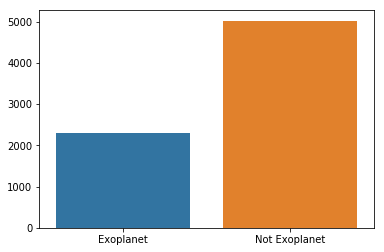

In [4]:
c = collections.Counter(data[target_name])
sns.barplot(['Exoplanet', 'Not Exoplanet'], list(c.values()))

In [5]:
scoring = ['accuracy', 'precision', 'recall']
clf = RandomForestClassifier(random_state=0)
scores = cross_validate(clf, data[feature_names],
                        data[target_name]=='CONFIRMED', scoring=scoring,
                        cv=5, return_train_score=True)
print("Accuracy:\t\t", np.mean(scores['test_accuracy']))
print("Completeness:\t\t", np.mean(scores['test_recall']))
print("Contamination:\t\t", 1 - np.mean(scores['test_precision']))

Accuracy:		 0.9717141144851571
Completeness:		 0.9216046225253386
Contamination:		 0.01244404296104129




In [6]:
clf.fit(data[feature_names], data[target_name])
values = list(zip(data[feature_names], clf.feature_importances_))
sortd = sorted(values, reverse = True, key= lambda x: x[1])
important_names = [s[0] for s in sortd]
sortd[:10]

[('PRF Delta Theta SQ (OOT) [arcsec]', 0.07135823290702711),
 ('Stellar Metallicity Lower Uncertainty [dex]', 0.06804977715237262),
 ('Number of Planets', 0.0646407175392276),
 ('Stellar Eclipse False Positive Flag', 0.06046033426970374),
 ('Centroid Offset False Positive Flag', 0.05654587021460088),
 ('Stellar Mass Upper Uncertainty [Solar mass]', 0.04799702351710492),
 ('Stellar Effective Temperature Upper Uncertainty [K]', 0.040739818002545294),
 ('PRF Delta Theta SQ (KIC) [arcsec]', 0.03989988308503265),
 ('Planetary Radius Lower Unc. [Earth radii]', 0.036104129216499706),
 ('Transit Duration Upper Uncertainty [hrs]', 0.02768457047526074)]

In [7]:
# Detect high VIFS in the features
from statsmodels.stats.outliers_influence import variance_inflation_factor
highVIFS = [
    'Planetary Radius Lower Unc. [Earth radii]', 
    'Planetary Radius [Earth radii]',
    'Stellar Effective Temperature Upper Uncertainty [K]',
    'Transit Duration Upper Uncertainty [hrs]',
    'Stellar Metallicity Upper Uncertainty [dex]',
]
noHighVIFS = list(set(important_names[:25]) - set(highVIFS))
X = data[noHighVIFS]
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif

,VIF Factor,features
0,1.633912,Stellar Radius Upper Uncertainty [Solar radii]
1,4.556510,Equilibrium Temperature [K]
2,2.424178,Stellar Eclipse False Positive Flag
3,2.321668,Transit Signal-to-Noise
4,1.124822,Planetary Radius Upper Uncertainty [Earth radii]
5,1.981609,Maximum Multiple Event Statistic
6,2.739582,Centroid Offset False Positive Flag
7,12.590921,Inclination [deg]
8,1.971146,Transit Duration Lower Uncertainty [hrs]
9,8.145201,PRF Delta Theta SQ (KIC) [arcsec]


In [9]:
# look at the 5 most important features with the canidate data
i5 = important_names[:5]
df5 = raw[[*i5, target_name]]
i3 = important_names[:3]
# remove outliers for graphing
# df5[i5] = df5[i5].mask(df5[i5].sub(df5[i5].mean()).div(df5[i5].std()).abs().gt(2))
# log transform for graphing
df5[important_names[0]] = df5[important_names[0]].apply(np.log)
# df5[important_names[1:4]].groupby(target_name).hist(alpha=0.5)
# df5[important_names[1]] = df5[important_names[1]].apply(np.log)
# df5[important_names[4]] = df5[important_names[4]].apply(np.log)
sns.pairplot(df5, hue=target_name, height=3)
# fig, axs = plt.subplots(figsize=(20,20), nrows=2, ncols=2)
# colors = ['red', 'blue', 'green']
# target_names = data[target_name].unique()
# for i in range(2):
#     for j in range(2):
#         feature = data[important_names[i*j]]
#         ax=axs[i][j]
#         color=colors[(i*j)%3]
#         print(list(data.groupby(target_name)[feature]))
#         plt.hist(list(data.groupby(target_name)[feature]))
#         for tn in target_names:
#             line = feature[data[target_name] == tn]
#             sns.distplot(line, ax=ax, color=color)


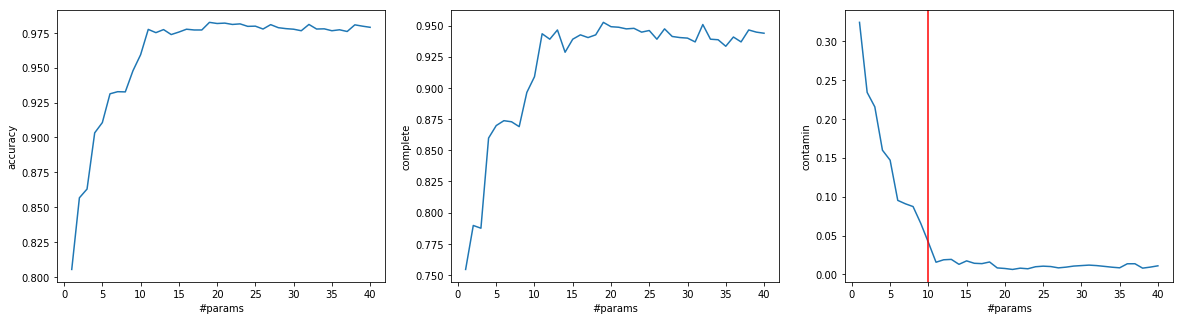

In [10]:
# Rerun using only the top most important features
test = []
for i in range(1, 41):
    imp = important_names[:i]
    clf = RandomForestClassifier(random_state=0)
    clf.fit(data[imp], data[target_name])
    scoring = ['accuracy', 'precision', 'recall']
    scores = cross_validate(clf, data[imp],
                            data[target_name]=='CONFIRMED', scoring=scoring,
                            cv=5, return_train_score=True)
    test.append((i, np.mean(scores['test_accuracy']), np.mean(scores['test_recall']), 1 - np.mean(scores['test_precision'])))

df_test = pd.DataFrame(test, columns=['#params', 'accuracy', 'complete', 'contamin'])
fig, axs = plt.subplots(ncols=3, figsize=(20,5))
sns.lineplot(x="#params", y="accuracy", data=df_test, ax=axs[0])
sns.lineplot(x="#params", y="complete", data=df_test, ax=axs[1])
sns.lineplot(x="#params", y="contamin", data=df_test, ax=axs[2])
plt.axvline(x=10, color='red')

In [11]:
top_names = important_names[:20]

In [12]:
names = ["Nearest Neighbors", #"RBF SVM",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(n_neighbors=10),
    DecisionTreeClassifier(random_state=0),
    RandomForestClassifier(random_state=0),
    MLPClassifier(random_state=0),
    AdaBoostClassifier(n_estimators=100, random_state=0),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

/usr/local/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/site-packages/sklearn/discriminan

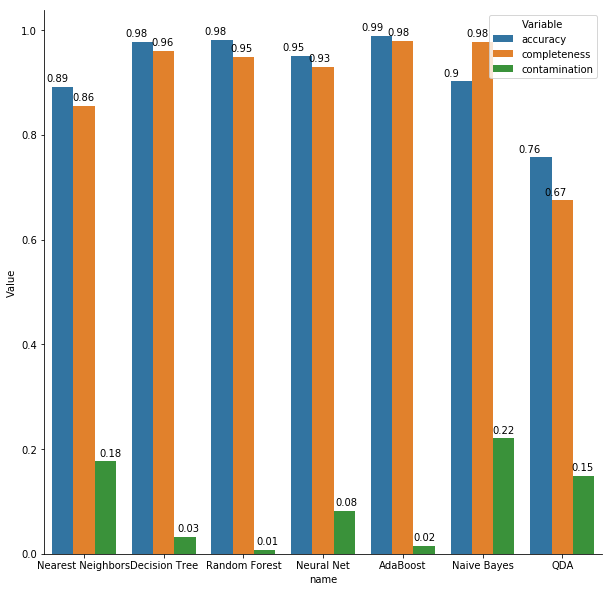

In [13]:
scoring = ['accuracy', 'precision', 'recall']
scores_list = []
# iterate over classifiers
for name, clf in zip(names, classifiers):
    scores = cross_validate(clf, data[top_names],
                            data[target_name]=='CONFIRMED', scoring=scoring,
                            cv=5, return_train_score=True)
    scores_list.append([name, np.mean(scores['test_accuracy']), np.mean(scores['test_recall']), 1 - np.mean(scores['test_precision'])])

scores_df = pd.DataFrame(scores_list, columns=['name', 'accuracy', 'completeness', 'contamination'])
fig, ax1 = plt.subplots(figsize=(10, 10))
tidy = (
    scores_df.set_index('name')
      .stack()  # un-pivots the data 
      .reset_index()  # moves all data out of the index
      .rename(columns={'level_1': 'Variable', 0: 'Value'})
)
g = sns.barplot(x='name', y='Value', hue='Variable', data=tidy, ax=ax1)
for index, row in tidy.iterrows():
    g.text((row.name-1)/3.04,row.Value + .01, round(row.Value,2), color='black', ha="center")
sns.despine(fig)

In [14]:
clf = RandomForestClassifier(n_jobs=-1, random_state=0)

param_grid = {
    'n_estimators' : [500],
    'max_depth': [10],
    'max_features': [10]
}

scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}

X_train, X_test, y_train, y_test = \
    train_test_split(data[top_names],
                     data[target_name] == 'CONFIRMED',
                     test_size=.4,
                     random_state=0)

Best params for completeness
{'max_depth': 10, 'max_features': 10, 'n_estimators': 500}
Completion: 0.9663119120661849

Confusion matrix of Random Forest optimized for completeness:


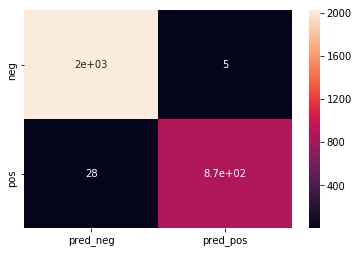

In [15]:
skf = StratifiedKFold(n_splits=4)
grid_search = GridSearchCV(clf, param_grid, scoring=scorers, refit='recall_score',
                       cv=skf, return_train_score=True, n_jobs=-1)
grid_search.fit(X_train, y_train)

# make the predictions
y_pred = grid_search.predict(X_test)

print('Best params for completeness')
print(grid_search.best_params_)
results = pd.DataFrame(grid_search.cv_results_)
bestResults = results[results.params == grid_search.best_params_]
completeness = float(bestResults['mean_test_recall_score'])
print('Completion:', completeness)
# confusion matrix on the test data.
print('\nConfusion matrix of Random Forest optimized for completeness:')
confusion = pd.DataFrame(confusion_matrix(y_test, y_pred),
             columns=['pred_neg', 'pred_pos'], index=['neg', 'pos'])
sns.heatmap(confusion, annot=True)

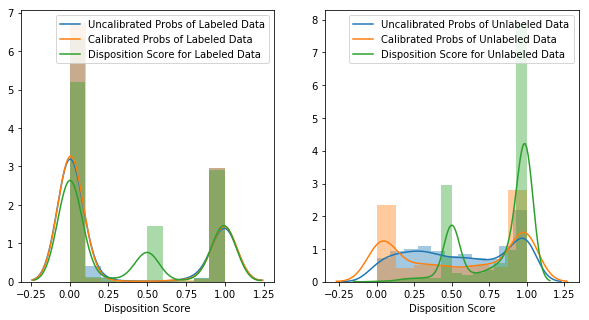

In [16]:
clf = RandomForestClassifier(random_state=0)
X_labeled, y = data[top_names], data[target_name]
clf.fit(X_labeled, y)
X_candidates = raw_withoutna[top_names][raw[target_name] == 'CANDIDATE']
calibrated = CalibratedClassifierCV(clf, method='isotonic')
calibrated.fit(X_labeled, y)

probs_labeled = [x[0] for x in clf.predict_proba(X_labeled)]
probs_calib_labeled = [x[0] for x in calibrated.predict_proba(X_labeled)]
probs_unlabeled = [x[0] for x in clf.predict_proba(X_candidates)]
probs_calib_unlabeled = [x[0] for x in calibrated.predict_proba(X_candidates)]

fig, axs = plt.subplots(ncols=2, figsize=(10,5))
sns.distplot(probs_labeled, ax=axs[0], kde_kws={"label": "Uncalibrated Probs of Labeled Data"})
sns.distplot(probs_calib_labeled, ax=axs[0], kde_kws={"label": "Calibrated Probs of Labeled Data"})
sns.distplot(raw['Disposition Score'][raw[target_name] != 'CANDIDATE'].dropna(), ax=axs[0], kde_kws={"label": "Disposition Score for Labeled Data"})
sns.distplot(probs_unlabeled, ax=axs[1], kde_kws={"label": "Uncalibrated Probs of Unlabeled Data"})
sns.distplot(probs_calib_unlabeled, ax=axs[1], kde_kws={"label": "Calibrated Probs of Unlabeled Data"})
sns.distplot(raw['Disposition Score'][raw[target_name] == 'CANDIDATE'].dropna(), ax=axs[1], kde_kws={"label": "Disposition Score for Unlabeled Data"})

In [29]:
# lets look at a couple of the highest probability exoplanets
X_candidates['probs'] = probs_calib_unlabeled
X_candidates.sort_values(['probs'], ascending=False)[important_names[:5]].head(10)

,PRF Delta Theta SQ (OOT) [arcsec],Stellar Metallicity Lower Uncertainty [dex],Number of Planets,Stellar Eclipse False Positive Flag,Centroid Offset False Positive Flag
3919,0.330,-0.15,1,0,0
4101,0.340,-0.15,1,0,0
1669,1.350,-0.15,4,0,0
2508,0.220,-0.30,1,0,0
1660,0.400,-0.15,2,0,0
2514,0.171,-0.30,1,0,0
2517,0.080,-0.15,1,0,0
6852,0.450,-0.15,1,0,0
2533,0.540,-0.30,1,0,0
1642,0.350,-0.15,1,0,0


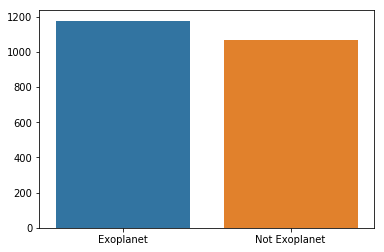

In [53]:
c = collections.Counter(list(calibrated.predict(X_candidates[top_names])))
sns.barplot(['Exoplanet', 'Not Exoplanet'], list(c.values()))

In [35]:
df_candidate_mask = pd.read_csv('candidateLikeData.csv')
mask = list(df_candidate_mask['Candidate Classifier Flag'] == 1)
df_candidate = data[mask]
df_candidate[important_names[:10]].head()

,PRF Delta Theta SQ (OOT) [arcsec],Stellar Metallicity Lower Uncertainty [dex],Number of Planets,Stellar Eclipse False Positive Flag,Centroid Offset False Positive Flag,Stellar Mass Upper Uncertainty [Solar mass],Stellar Effective Temperature Upper Uncertainty [K],PRF Delta Theta SQ (KIC) [arcsec],Planetary Radius Lower Unc. [Earth radii],Transit Duration Upper Uncertainty [hrs]
3,0.289,-0.30,1,1,0,0.093,157.0,0.276,-2.83,0.00537
4,0.100,-0.30,1,0,0,0.151,169.0,0.070,-0.35,0.04200
6,0.260,-0.30,3,0,0,0.135,189.0,0.190,-0.30,0.06730
7,0.450,-0.30,3,0,0,0.135,189.0,0.500,-0.17,0.16500
11,3.970,-0.15,1,1,0,0.070,76.0,4.190,-0.91,0.00203


In [52]:
data['Candidate-like Data Flag'] = df_candidate_mask['Candidate Classifier Flag']
(_, train), (_, test) = data.groupby(['Candidate-like Data Flag'])
print(len(train), len(test))

3405 2188


In [73]:
# test how well a random forest does on labeled data
# that is most like our unlabeled/candidate data
clf = RandomForestClassifier(random_state=0)
X, y = train[top_names], train[target_name]
clf.fit(X, y)
y_true = test[target_name]
y_pred = clf.predict(test[top_names])
accuracy = accuracy_score(y_true=='CONFIRMED', y_pred=='CONFIRMED')
complete = recall_score(y_true=='CONFIRMED', y_pred=='CONFIRMED')
contamin = 1 - precision_score(y_true=='CONFIRMED', y_pred=='CONFIRMED')
print("Accuracy:\t\t", accuracy)
print("Completeness:\t\t", complete)
print("Contamination:\t\t", contamin)

Accuracy:		 0.9835466179159049
Completeness:		 0.9800884955752213
Contamination:		 0.019911504424778736
